In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import random
import homebrew as hb
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

# Collect playlists

In [2]:
with open('/Users/patrickfuller/.secrets/spotify_api.json') as f:
    creds = json.load(f)
client_id = creds['client_id']
key = creds['api_key']

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id,
                                                      client_secret=key)

spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [9]:
cat_list = []
response = spotify.categories(country='US', limit=50)
items = response['categories']['items']
for item in items:
    category = item['id']
    cat_list.append(category)

In [10]:
for cat in ['family', 'comedy', 'word', 'ellen', 'sleep']:   
    cat_list.remove(cat)

In [12]:
master_playlist_dict = {}
for category in cat_list:
    offset = 0
    while True:
        response = spotify.category_playlists(category_id=category,
                                                             offset=offset,
                                                             limit=50, country='US',
                                                             )
        current_names_ids = hb.extract_name_and_id(response)
        if current_names_ids == {}:                     # If we run out of playlists in a category
            break                                       # we move on to the next category
        master_playlist_dict.update(current_names_ids)
        offset += 50

In [25]:
# with open('playlists_artists_redundant.json', 'w') as f:
#     for pl_id, pl_data in list(master_playlist_dict.items()):
#         pl_artists = []
#         offset = 0
#         for _ in range(2):
#             try:
#                 response = spotify.user_playlist_tracks(user=pl_data['owner_id'],
#                                              playlist_id=pl_id,
#                                              limit=100)
#                 current_artists = hb.get_artists_in_playlist(response)
#                 pl_artists.extend(current_artists)
#                 unique = set(pl_artists)
#                 for artist in unique:
#                     line = {
#                         'artist':(artist),
#                         'playlist':(pl_data['name'], pl_id),
#                     }
#                     json.dump(line, f)
#                     f.write('\n')
#             except:
#                 pass

# # Commented out to prevent re-writing the file. Doesn't take for ever but non-negligeable

# Eda and Clean

In [6]:
df = pd.read_json('playlists_artists_redundant.json', lines=True)

In [7]:
display(df.shape)
df.head()

(218706, 2)

,artist,playlist
0,DJ Snake,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
1,TINI,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
2,Bon Iver,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
3,Jon Z,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
4,Martin Garrix,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"


In [8]:
len(df.artist.unique())

43786

## Artist Occurances

In [9]:
df.artist.value_counts()[:50]  # These artists are showing up in the most playlists

J Balvin                     248
Bad Bunny                    214
Drake                        202
Cardi B                      186
Daddy Yankee                 182
Farruko                      180
Nicky Jam                    178
Ozuna                        176
Maluma                       174
Khalid                       172
Ed Sheeran                   170
Nicki Minaj                  165
Camila Cabello               150
Marshmello                   146
Justin Bieber                146
Diplo                        144
Beyoncé                      143
Ty Dolla $ign                138
Anuel Aa                     136
Shawn Mendes                 132
Zion & Lennox                132
Wisin                        128
Rihanna                      128
Natti Natasha                124
Post Malone                  122
Taylor Swift                 122
Mark Ronson                  122
French Montana               118
Maren Morris                 118
Tyga                         117
Katy Perry

Text(0.5, 1.0, 'Artist Appearance in Playlists')

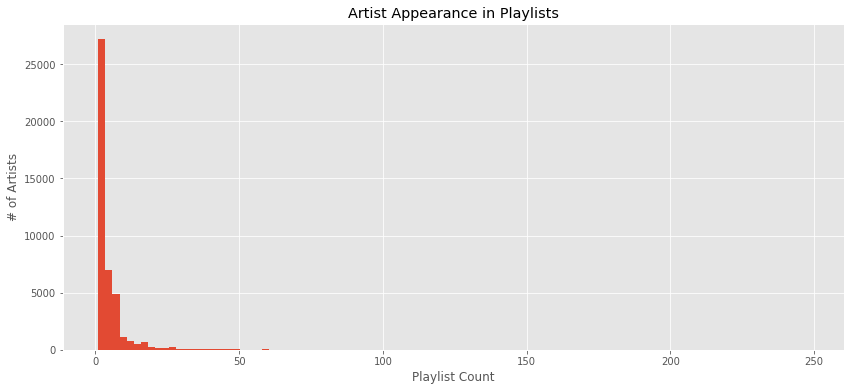

In [10]:
plt.figure(figsize=(14,6))
df.artist.value_counts().hist(bins=100)
plt.xlabel('Playlist Count')
plt.ylabel('# of Artists')
plt.title('Artist Appearance in Playlists')

We won't be able to gain much information from artists only appearing in a few playlists.
Dropping them will reduce computational cost with little to no cost to predictive power.

## Trim rarer artists

In [11]:
cutoff = 20

top_artists_counts = [(v, c) for v, c in df.artist.value_counts().items()
                      if c >= cutoff]
n_remaning_artists = len(top_artists_counts)
print(f'There are {n_remaning_artists} artists appearing in {cutoff} or more playlists')
print('The top twelve are ...')
top_artists_counts[:12]

There are 1697 artists appearing in 20 or more playlists
The top twelve are ...


[('J Balvin', 248),
 ('Bad Bunny', 214),
 ('Drake', 202),
 ('Cardi B', 186),
 ('Daddy Yankee', 182),
 ('Farruko', 180),
 ('Nicky Jam', 178),
 ('Ozuna', 176),
 ('Maluma', 174),
 ('Khalid', 172),
 ('Ed Sheeran', 170),
 ('Nicki Minaj', 165)]

In [12]:
top_artists=[x[0] for x in top_artists_counts]
trimmed_df = df[df.artist.isin(top_artists)].copy()
trimmed_df.shape

(65242, 2)

Text(0.5, 1.0, 'Artist Appearance in Playlists')

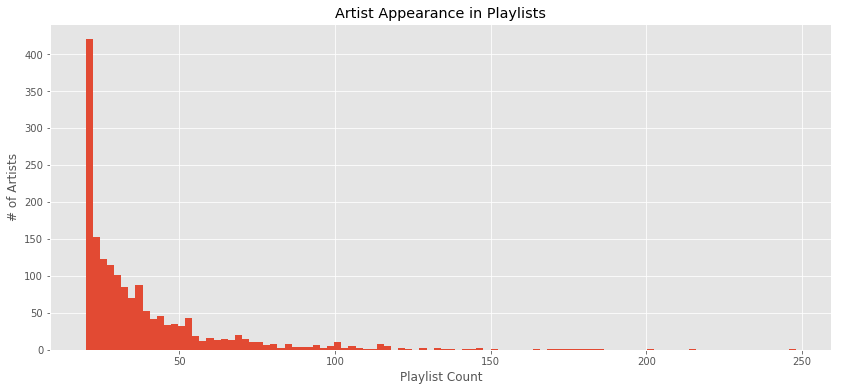

In [13]:
plt.figure(figsize=(14,6))
trimmed_df.artist.value_counts().hist(bins=100)
plt.xlabel('Playlist Count')
plt.ylabel('# of Artists')
plt.title('Artist Appearance in Playlists')

In [14]:
trimmed_df.playlist = df.playlist.apply(lambda x: x[1]) # OneHot doesn't like lists or sets

In [15]:
trimmed_df.head(2)

,artist,playlist
0,DJ Snake,37i9dQZF1DXcBWIGoYBM5M
1,TINI,37i9dQZF1DXcBWIGoYBM5M


## One Hot Flag Playlist Presence

In [16]:
encoder = OneHotEncoder(drop='first', categories='auto')
encoder.fit(trimmed_df[['playlist']])

ohe_playlists= pd.DataFrame(encoder.transform(trimmed_df[['playlist']]).toarray(),
                          columns=encoder.get_feature_names(['playlist']))

In [17]:
artists_ohe_playlists = pd.concat([trimmed_df.drop('playlist', axis=1),
                                   ohe_playlists],
                                   axis=1)          # Making a column for each unique playlist

In [18]:
artists_ohe_playlists.shape

(104530, 1553)

In [19]:
artist_w_flagged_playlists = artists_ohe_playlists.groupby('artist').sum() 
            
    # Stacking artists to flag each playlist per row

In [20]:
print(artist_w_flagged_playlists.shape)
artist_w_flagged_playlists.head(20)

(1697, 1552)


,playlist_08CJ6fWrTA1vMfwVwAxWUl,playlist_0Gy1TwCxPFTMCiwxGLVkc1,playlist_0T22esVKW7cTZEN7XzXV14,playlist_0YMVY3uhQNd7WUf0hSByrX,playlist_0ZWYUjUMhaq0Rammqq3qu1,playlist_0bx5Dgu5yOEhST49LP67su,playlist_0fmLn46c92nP4dePQSZlsz,playlist_0k7YwkrfJ2BsRMFBP5W5xK,playlist_0yfTPCk6Cnhm9wtoEaXXlo,playlist_13thjkLTYZmZvjdz4u6kxh,...,playlist_73gXbLcjix7p1pPsQClusE,playlist_7A2YimOfIrmAWkCeSIY8Rq,playlist_7EnyqmmhFgfhicejZiVV13,playlist_7EpJpnU6KrSc430F8B5tM7,playlist_7FDyC1JdV3jkGzAE9BONKt,playlist_7HQu1GUDVSx64GdCpaB88I,playlist_7JXJKP3xMvIMbEBBGApTPQ,playlist_7b9DiMN2kttG8lYQogfQBw,playlist_7fzFQUIVM4TumzRWo5UFP2,playlist_7kdOsNnHtzwncTBnI3J17w
artist,,,,,,,,,,,,,,,,,,,,,
(G)I-DLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
*NSYNC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2 Chainz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21 Savage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2Pac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3 Doors Down,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3LAU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5 Seconds of Summer,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50 Cent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
# artist_w_flagged_playlists.drop("", inplace=True)     
                
#     # If playlist_count cutoff is lower, empty('') Artist 
#     # shows up and should be removed.

In [22]:
idx_artists_and_flags = artist_w_flagged_playlists.reset_index()
idx_artists_and_flags.head()

,artist,playlist_08CJ6fWrTA1vMfwVwAxWUl,playlist_0Gy1TwCxPFTMCiwxGLVkc1,playlist_0T22esVKW7cTZEN7XzXV14,playlist_0YMVY3uhQNd7WUf0hSByrX,playlist_0ZWYUjUMhaq0Rammqq3qu1,playlist_0bx5Dgu5yOEhST49LP67su,playlist_0fmLn46c92nP4dePQSZlsz,playlist_0k7YwkrfJ2BsRMFBP5W5xK,playlist_0yfTPCk6Cnhm9wtoEaXXlo,...,playlist_73gXbLcjix7p1pPsQClusE,playlist_7A2YimOfIrmAWkCeSIY8Rq,playlist_7EnyqmmhFgfhicejZiVV13,playlist_7EpJpnU6KrSc430F8B5tM7,playlist_7FDyC1JdV3jkGzAE9BONKt,playlist_7HQu1GUDVSx64GdCpaB88I,playlist_7JXJKP3xMvIMbEBBGApTPQ,playlist_7b9DiMN2kttG8lYQogfQBw,playlist_7fzFQUIVM4TumzRWo5UFP2,playlist_7kdOsNnHtzwncTBnI3J17w
0,(G)I-DLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,*NSYNC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2 Chainz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21 Savage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2Pac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
idx_artists_and_flags.to_json('trimmed_artists_w_flags.json', orient='records', lines=True)

## Finding Artist with similar playlist occurances

In [24]:
from sklearn.neighbors import NearestNeighbors

In [25]:
X = idx_artists_and_flags.drop('artist', axis=1)

In [26]:
neighbors = NearestNeighbors(n_neighbors=20, metric='cosine', n_jobs=-1)

In [34]:
neighbors.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [33]:
distances, indices = neighbors.kneighbors(X)

In [29]:
distances[0]

array([2.22044605e-16, 2.22044605e-16, 2.22044605e-16, 2.92893219e-01,
       5.00000000e-01, 5.91751710e-01, 6.46446609e-01, 6.46446609e-01,
       6.46446609e-01, 7.11324865e-01, 7.11324865e-01, 7.41801110e-01,
       7.95875855e-01, 8.49244328e-01, 8.55662433e-01, 8.61324951e-01,
       8.70900555e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [30]:
indices[0]

array([1311,    0,  194, 1246,  432,  951,  338,  539,  950, 1445,  239,
        130, 1216,  510,  512,  152, 1417, 1126, 1138, 1125])

In [31]:
artist_idx = random.randint(0, n_remaning_artists)                    # Pick a random artist
artist = idx_artists_and_flags.loc[artist_idx, 'artist']
print(f'- - Artist: {artist} - -')

sim_artist_indxs = indices[artist_idx]       # Taking one row of the nearest neighbors result
sim_artist_dists = distances[artist_idx]

for d, i in zip(sim_artist_dists, sim_artist_indxs):
    similar_artist = idx_artists_and_flags.loc[i,'artist']
    print(f'Closness of Artists:{round(d, 2)} {similar_artist}')

- - Artist: Frederick Delius - -
Closness of Artists:0.0 Frederick Delius
Closness of Artists:0.0 Sergei Prokofiev
Closness of Artists:0.0 Cleveland Orchestra
Closness of Artists:0.29 José Serebrier
Closness of Artists:0.29 Royal Scottish National Orchestra
Closness of Artists:0.29 Berliner Philharmoniker
Closness of Artists:0.29 Lang Lang
Closness of Artists:0.29 John Eliot Gardiner
Closness of Artists:0.42 Anne-Sophie Mutter
Closness of Artists:0.42 Benjamin Britten
Closness of Artists:0.5 Antonio Vivaldi
Closness of Artists:0.5 Bamberg Symphony
Closness of Artists:0.5 Samuel Barber
Closness of Artists:0.5 Hector Berlioz
Closness of Artists:0.5 André Previn
Closness of Artists:0.5 Arnold Bax
Closness of Artists:0.5 Vladimir Ashkenazy
Closness of Artists:0.5 Royal Philharmonic Orchestra
Closness of Artists:0.5 George Gershwin
Closness of Artists:0.5 Claudio Abbado


In [43]:
artist = input()
print(f'- - Artist: {artist} - -')
artist_idx = idx_artists_and_flags[idx_artists_and_flags.artist == artist].index[0]

sim_artist_indxs = indices[artist_idx]       # Taking one row of the nearest neighbors result
sim_artist_dists = distances[artist_idx]

for d, i in zip(sim_artist_dists, sim_artist_indxs):
    similar_artist = idx_artists_and_flags.loc[i,'artist']
    print(f'Closness of Artists:{round(d, 2)} {similar_artist}')

 Jason Aldean


- - Artist: Jason Aldean - -
Closness of Artists:0.0 Jason Aldean
Closness of Artists:0.37 Luke Combs
Closness of Artists:0.4 Jordan Davis
Closness of Artists:0.42 Old Dominion
Closness of Artists:0.43 Thomas Rhett
Closness of Artists:0.43 Luke Bryan
Closness of Artists:0.45 Dan + Shay
Closness of Artists:0.46 Florida Georgia Line
Closness of Artists:0.47 Brett Young
Closness of Artists:0.48 LANCO
Closness of Artists:0.49 Rodney Atkins
Closness of Artists:0.5 Maren Morris
Closness of Artists:0.5 Keith Urban
Closness of Artists:0.5 Dustin Lynch
Closness of Artists:0.53 Sam Hunt
Closness of Artists:0.53 Lauren Alaina
Closness of Artists:0.53 Lee Brice
Closness of Artists:0.53 Zac Brown Band
Closness of Artists:0.54 Kenny Chesney
Closness of Artists:0.54 Kane Brown
